In [31]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [32]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils
from modules import helpers, training
from modules.nn import mlp, pca

In [33]:
import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)

importlib.reload(mlp)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [34]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [35]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [36]:
four_leptons_data = utils.FourLeptonsData()
four_leptons_nn = utils.FourLeptonNN()

In [37]:
print('Higgs:')
mc_higgs_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'higgs2011.csv',
            MC_dir + 'higgs2012.csv'
        ]
    ],
    show_cut_info=True
)

print('ZZ:')
mc_zz_all_data = four_leptons_data.apply_basic_cuts(
    [ 
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'zzto4mu2011.csv',
            MC_dir + 'zzto2mu2e2011.csv',
            MC_dir + 'zzto4e2011.csv',

            MC_dir + 'zzto4mu2012.csv',
            MC_dir + 'zzto2mu2e2012.csv',
            MC_dir + 'zzto4e2012.csv',
        ]
    ],
    show_cut_info=True
)

print('Drell-Yan:')
mc_dy_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'dy1050_2011.csv',
            MC_dir + 'dy50_2011.csv',
            MC_dir + 'dy1050_2012.csv',
            MC_dir + 'dy50_2012.csv'
        ]
    ],
    show_cut_info=True
)

print('tt:')
mc_tt_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'ttbar2011.csv',
            MC_dir + 'ttbar2012.csv'
        ]
    ],
    show_cut_info=True
)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Z cut: 41818 events passed out of 44320 (94%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
 Z cut: 33996 events passed out of 35855 (95%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Z cut: 123286 events passed out of 162016 (76%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Z cut: 68099 events passed out of 110224 (62%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Z cut: 78064 events passed out of 93161 (84%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Z cut: 116017 events passed out of 148678 (78%)
 Conservation cut: 12

In [38]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = four_leptons_data.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = four_leptons_data.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = four_leptons_data.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

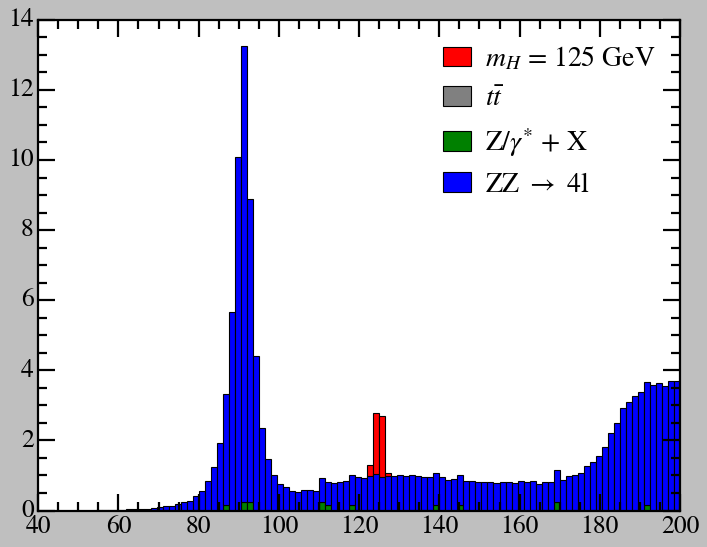

In [39]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [40]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self,
                 all_data,data_labels,
                 fields,field_indices):
        self.all_data = all_data
        self.event_nums = [len(data) for data in all_data]
        self.all_labels = [np.array([label]*len(data)) for label,data in zip(data_labels,all_data)]

        self.fields = fields
        self.field_indices = [field_indices[field] for field in fields]

    def _subsample(self, data, label, n):
        idx = np.random.choice(len(data), n, replace=False)
        return data[idx], label[idx]
    
    def get_pca(self):
        X = []
        Y = []

        for data,label in zip(self.all_data,self.all_labels):
            reduced_data, reduced_label = self._subsample(data,label,min(self.event_nums))
            X.append(reduced_data)
            Y.append(reduced_label)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        return X_pca.numpy()[Y==1], X_pca.numpy()[Y==0]

In [41]:
mc_all_data = mc_higgs_all_data + mc_zz_all_data
fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(all_data=mc_all_data,
                            data_labels=[1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
                            fields=fields,
                            field_indices=params.field_indices)
higgs_pca, zz_pca = mc_all_pca.get_pca()

In [42]:
if False:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,0.5)

        plt.tight_layout()
        plt.show()

In [43]:
all_higgs_and_zz_data = [
    four_leptons_data.read_data(file) for file in [
        MC_dir + 'higgs2011.csv',
        MC_dir + 'higgs2012.csv',

        MC_dir + 'zzto4mu2011.csv',
        MC_dir + 'zzto2mu2e2011.csv',
        MC_dir + 'zzto4e2011.csv',
        MC_dir + 'zzto4mu2012.csv',
        MC_dir + 'zzto2mu2e2012.csv',
        MC_dir + 'zzto4e2012.csv',
    ]
]

all_higgs_and_zz_data = four_leptons_data.apply_basic_cuts(
    all_higgs_and_zz_data, show_cut_info=False
)

fields = [
    'px1','py1',
    'px2','py2',
    'px3','py3',
    'px4','py4',
]

X_higgs_and_zz, Y_higgs_and_zz = four_leptons_nn.get_training_data(
    all_data = all_higgs_and_zz_data,
    data_labels = [1]*2 + [0]*6,
    fields = fields,
)
higgs_and_zz_train_loader, higgs_and_zz_val_loader, N_data, N_train, N_val = four_leptons_nn.get_training_dataloaders(
    X_higgs_and_zz, Y_higgs_and_zz,
    train_ratio=0.8,
    batch_size=2048,
    num_workers=8,
    seed=42,
)

In [44]:
N_data

151628

In [45]:
model = mlp.MLP(
    input_dim=8,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [46]:
trainer = training.SupervisedTraining(
    model=model,
    train_loader=higgs_and_zz_train_loader,
    val_loader=higgs_and_zz_val_loader,
    num_epochs=50,
    lr=5e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [47]:
trainer.train(save_training_stats_every=5, save_model_every=None, outpath='training_result/MLP_reduced/')

Training:   2%|▏         | 1/50 [00:11<09:21, 11.47s/it]

Epoch 1/50 - Train Loss: 0.53139 - Val Loss: 0.49097


Training:  10%|█         | 5/50 [00:51<07:33, 10.07s/it]

Epoch 5/50 - Train Loss: 0.36637 - Val Loss: 0.35917


Training:  20%|██        | 10/50 [01:40<06:38,  9.96s/it]

Epoch 10/50 - Train Loss: 0.32970 - Val Loss: 0.32804


Training:  30%|███       | 15/50 [02:31<05:49,  9.99s/it]

Epoch 15/50 - Train Loss: 0.30864 - Val Loss: 0.31042


Training:  40%|████      | 20/50 [03:20<04:59,  9.98s/it]

Epoch 20/50 - Train Loss: 0.29735 - Val Loss: 0.30394


Training:  50%|█████     | 25/50 [04:10<04:08,  9.95s/it]

Epoch 25/50 - Train Loss: 0.29191 - Val Loss: 0.29761


Training:  60%|██████    | 30/50 [05:00<03:19,  9.96s/it]

Epoch 30/50 - Train Loss: 0.28930 - Val Loss: 0.29764


Training:  70%|███████   | 35/50 [05:50<02:28,  9.89s/it]

Epoch 35/50 - Train Loss: 0.28679 - Val Loss: 0.29607


Training:  80%|████████  | 40/50 [06:39<01:39,  9.91s/it]

Epoch 40/50 - Train Loss: 0.28143 - Val Loss: 0.29293


Training:  90%|█████████ | 45/50 [07:29<00:49,  9.91s/it]

Epoch 45/50 - Train Loss: 0.28065 - Val Loss: 0.29410


Training: 100%|██████████| 50/50 [08:18<00:00,  9.97s/it]

Epoch 50/50 - Train Loss: 0.27909 - Val Loss: 0.29969


In [48]:
training_stats = pickle.load(open('training_result/MLP_reduced/training_stats.pkl', 'rb'))

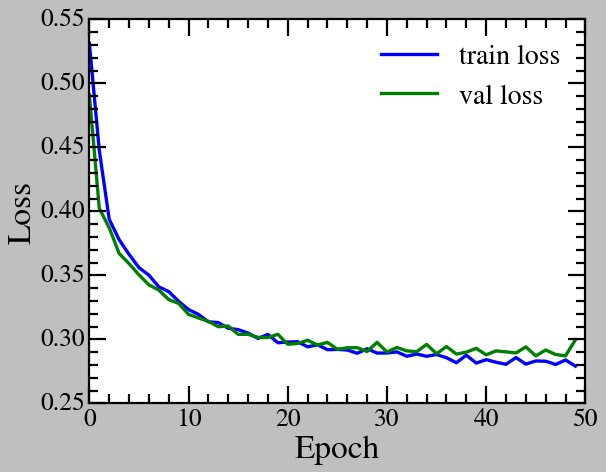

In [49]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

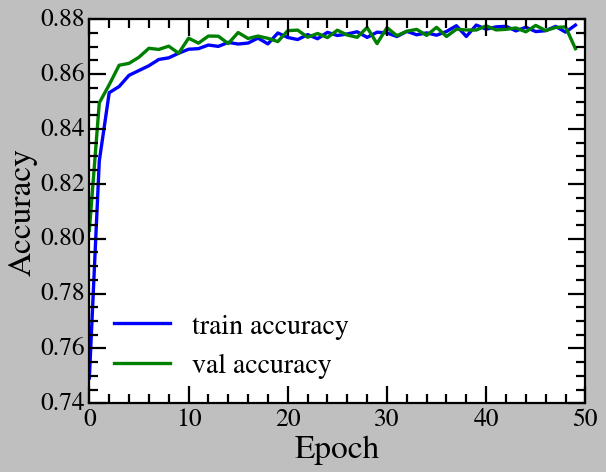

In [50]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [51]:
best_model_idx = np.argmin(training_stats['val_losses'])

print('Best detection rate:', training_stats['val_P_detections'][best_model_idx])
print('Best false alarm rate:', training_stats['val_P_false_alarms'][best_model_idx])

Best detection rate: 0.9341288089752198
Best false alarm rate: 0.1785719225804011


In [52]:
best_state_dict = torch.load('training_result/MLP_reduced/model/best.pth')['model_state_dict']
model.load_state_dict(best_state_dict)

/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_90639/1989645927.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load('training_result

<All keys matched successfully>

In [53]:
nn_higgs_and_zz_data = four_leptons_nn.apply_nn_cut(
    all_higgs_and_zz_data, fields=fields, 
    model=model, batch_size=2048, num_workers=8,
    threshold=0.5, device='mps'
)

nn_higgs_data = nn_higgs_and_zz_data[:2]
nn_zz_data = nn_higgs_and_zz_data[2:]

In [54]:
bins = np.linspace(50,200,51)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

nn_higgs_hist = four_leptons_data.get_histogram(nn_higgs_data, params.scales_higgs, 'm4l', bins) 
nn_zz_hist = four_leptons_data.get_histogram(nn_zz_data, params.scales_zz, 'm4l', bins)

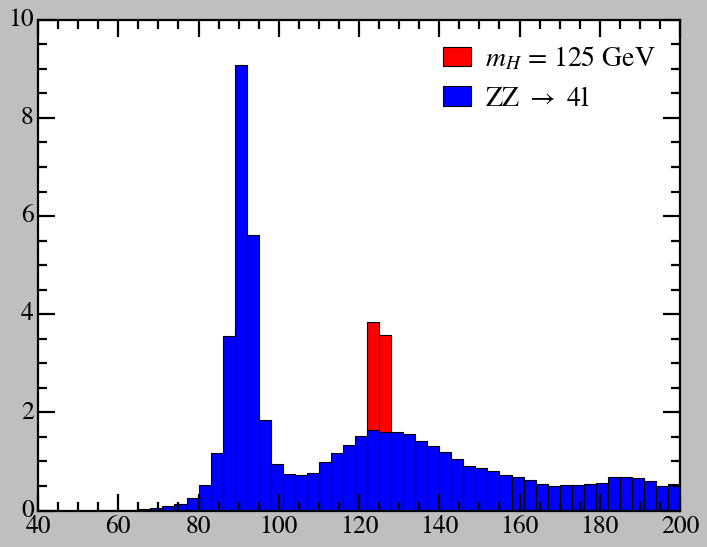

In [55]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, nn_higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, nn_zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue')

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()